In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import graphviz
import torch_geometric
from torch_geometric.data import Dataset, Data, InMemoryDataset
from SALBP_solve import *
import os.path as osp
import ast
from sklearn.preprocessing import MinMaxScaler
import torchmetrics
import sys
import os

sys.path.append(os.path.abspath("torch"))
from salb_dataset import *
from gnns import *

In [2]:



my_dataset = SALBDataset(root='pytorch_datasets/medium',edge_data_csv ="medium_res_data_good_rows.csv",  alb_filepath=os.path.normpath("../../MALBPW/MMABPW/SALBP_benchmark/medium data set_n=50/"), raw_data_folder ="pytorch_datasets/medium/raw/")


In [3]:
my_dataset[22]

/home/jot240/DADA/DADA/torch/salb_dataset.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load( self.processed_dir +row['instance'] + ".pt")


Data(x=[50, 1], edge_index=[2, 51], instance='instance_n=50_12', precendence_relation=[51], edge_classes=[51], graph_class=False, n_stations=[51])

In [4]:
#! rm -r pytorch_datasets/medium/processed/

In [5]:
my_dataset[3]

Data(x=[50, 1], edge_index=[2, 68], instance='instance_n=50_102', precendence_relation=[68], edge_classes=[68], graph_class=True, n_stations=[68])

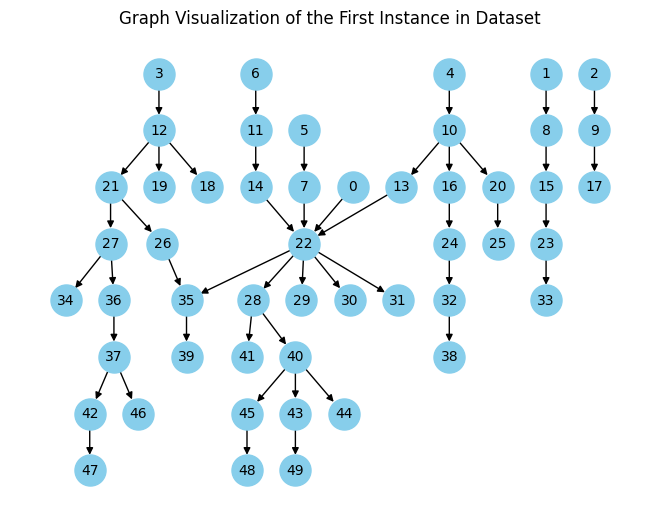

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming the first graph in my_dataset is at index 0
data = my_dataset[0]
def plot_pytorch_graph(data):
    # Create a NetworkX graph from the PyTorch Geometric Data object
    graph = nx.DiGraph()
    edge_index = data.edge_index.numpy()
    #adds nodes
    for j in range(data.x.shape[1]):
        graph.add_node(j)
    #adds edges
    for i in range(edge_index.shape[1]):
        graph.add_edge(edge_index[0, i], edge_index[1, i])

    pos = nx.nx_pydot.graphviz_layout(graph, prog = "dot")

    # Draw the graph, changes graph to graphviz and uses
    nx.draw(graph, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black", pos=pos)

    plt.title("Graph Visualization of the First Instance in Dataset")
    plt.show()
plot_pytorch_graph(data)

In [7]:


# Count total positive and negative edges across all graphs
def get_pos_weight(data_list):
    num_pos = sum([data.graph_class for data in data_list])
    num_neg = len(data_list) - num_pos

    # Compute pos_weight for BCEWithLogitsLoss
    pos_weight = torch.tensor([num_neg / num_pos])  # Shape: (1,)
    return pos_weight
pos_weight = get_pos_weight(my_dataset)
#n_neg

/home/jot240/DADA/DADA/torch/salb_dataset.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load( self.processed_dir +row['instance'] + ".pt")


In [8]:
pos_weight

tensor([4.8310])

In [9]:
from torch_geometric.loader import DataLoader


In [ ]:

# Hyperparameters
in_channels = 1 # Assuming a single feature per node.
hidden_channels = 64
out_channels = 1 # Number of classes for your classification task.
learning_rate = 0.01
epochs = 10000
batch_size = 5#TODO: Make it work for larger batch sizes
#splits the data into train and test
input_dataset = my_dataset.copy()
train_dataset, test_dataset = random_split(input_dataset, [int(len(input_dataset)*0.8), len(input_dataset) - int(len(input_dataset)*0.8)])
# train_dataset = [input_dataset[3]]
# test_dataset = [input_dataset[3]]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

accuracy = torchmetrics.Accuracy(task="binary")
precision = torchmetrics.Precision(task="binary")
recall = torchmetrics.Recall(task="binary")
f1_score = torchmetrics.F1Score(task="binary")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device:", device)
model = GraphClassifier(in_channels, hidden_channels, out_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#loss_fn = torch.nn.BCEWithLogitsLoss()

criterion = nn.BCEWithLogitsLoss()
# Training loop
model.train()
for epoch in range(epochs):
    total_loss = 0
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(out.squeeze(1), data.graph_class.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')

    # Evaluation
    model.eval()
    #  Testing loop
    with torch.no_grad():
      total_loss = 0
      for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = loss_fn(out.squeeze(1), data.graph_class.float())
        probs = torch.sigmoid(out)
        print("average probability", probs.squeeze(1).float().mean())
        # Set a threshold to convert probabilities to binary predictions
        threshold = 0.5
        targets = data.graph_class
        preds = (probs > threshold).int().squeeze(1)
        acc = accuracy(preds, targets)
        prec = precision(preds, targets)
        rec = recall(preds, targets)
        f1 = f1_score(preds, targets)

        #correct = (predictions.squeeze(1) == data.edge_classes)  # Per-class correct predictions
        # print(correct)
        
        
        # Overall accuracy
        #overall_accuracy = (predictions.squeeze(1) == data.edge_classes).float().mean()

        # Print metrics

        #print(f"Correct: {correct.tolist()}")
        #print(f"Overall accuracy: {overall_accuracy.item()}")
        
        print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1:.4f}")


using device: cpu
Epoch 1, Loss: 1.0564086975446387
average probability tensor(0.2764)
Accuracy: 1.0000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3249)
Accuracy: 0.6000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.2471)
Accuracy: 1.0000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.2595)
Accuracy: 1.0000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.2695)
Accuracy: 0.8000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3475)
Accuracy: 0.8000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3139)
Accuracy: 0.6000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3212)
Accuracy: 1.0000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
average probability tensor(0.3116)
Accuracy: 0.8000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000
ave